# Positional Encoding

To include positional information, we need a way of encoding the position of a token in the same dimension as the token embedding in order to combine the two tensors. "Will be added to the token embedding, so they must have the same size"

***Non-trainable**

For given inputs

- <b>pos</b>: position of the token in the sequence
- <b>d</b>: dimension of the encoded output
- and 0 <= <b>i</b> <= d/2

the positional encoding compute as follows:

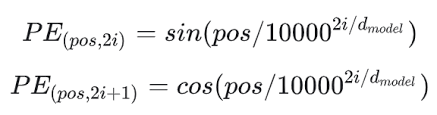

In [ ]:
%pip install torch
%pip install matplotlib

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_out: int):
        super().__init__()
        self.dim_out = dim_out  # Store embedding dimension (e.g., 100)
        self.n = 10000          # Base frequency constant from Transformer paper

    def forward(self, pos):
        # Create indices for dimension pairs
        i = torch.arange(0, self.dim_out // 2).float() # 50 Because we will use sin and cos for each dimension, in total, 100 dimensions.
        # Output: tensor([0., 1., 2., 3., ..., 49.]) for dim_out=100
        # Shape: [50] (half of dim_out)
        
        # Calculate denominator: 10000^(2i/d_model)
        denom = torch.pow(self.n, 2 * i / self.dim_out) # denominator value is the thing that affects the frequency, as higher the denominator, lower the frequency.
                                                                                                                      # lower the denominator, higher the frequency.
                                                                                                                      # Check the cell below for more details.
        # Output: tensor([1.0000, 1.5849, 2.5119, 3.9811, ..., 7943.2822])
        # Shape: [50] - frequencies from high (1.0) to low (7943.28)
        
        # Reshape pos for broadcasting
        pos = pos.view(-1, 1).float()
        # Input pos: tensor([0, 1, 2, ..., 199]) shape [200]
        # Output: tensor([[0.], [1.], [2.], ..., [199.]]) shape [200, 1]
        
        # Calculate sin and cos values
        angles = pos / denom
        # Output: tensor with shape [200, 50]
        # angles[0] = [0./1.0, 0./1.58, 0./2.51, ..., 0./7943] = [0, 0, 0, ...]
        # angles[1] = [1./1.0, 1./1.58, 1./2.51, ..., 1./7943] = [1.0, 0.63, 0.40, ...]
        # angles[10] = [10./1.0, 10./1.58, ..., 10./7943] = [10.0, 6.31, 3.98, ...]
        
        sin_vals = torch.sin(angles)
        # Output: tensor with shape [200, 50]
        # sin_vals[0] = [sin(0), sin(0), sin(0), ...] = [0, 0, 0, ...]
        # sin_vals[1] = [sin(1.0), sin(0.63), sin(0.40), ...] = [0.841, 0.589, 0.389, ...]
        
        cos_vals = torch.cos(angles)
        # Output: tensor with shape [200, 50]  
        # cos_vals[0] = [cos(0), cos(0), cos(0), ...] = [1, 1, 1, ...]
        # cos_vals[1] = [cos(1.0), cos(0.63), cos(0.40), ...] = [0.540, 0.808, 0.921, ...]
        
        # Initialize output tensor
        out = torch.zeros(pos.shape[0], self.dim_out)
        # Output: tensor with shape [200, 100] - all zeros initially
        
        # Fill even positions with sin, odd positions with cos
        out[:, 0::2] = sin_vals
        # Fills columns [0, 2, 4, 6, ..., 98] with sin values
        # out[:, 0] gets sin_vals[:, 0], out[:, 2] gets sin_vals[:, 1], etc.
        
        if self.dim_out % 2 == 1:
            out[:, 1::2] = cos_vals
        else:
            out[:, 1::2] = cos_vals
        # Fills columns [1, 3, 5, 7, ..., 99] with cos values  
        # out[:, 1] gets cos_vals[:, 0], out[:, 3] gets cos_vals[:, 1], etc.
        # Final shape: [200, 100]
            
        return out
        # Returns: tensor with shape [200, 100]
        # Each row is a unique positional encoding for that position
        # Each row alternates: [sin, cos, sin, cos, sin, cos, ...]
        # Row 0: [0, 1, 0, 1, 0, 1, ...] (sin(0)=0, cos(0)=1)
        # Row 1: [0.841, 0.540, 0.589, 0.808, ...] (different frequencies)

Check the file "PositionalEncoding/PositionalEncoding.html" to understand the effect of denominator value on the frequency.

Things to check:


High frequency dimensions (like sin(pos/SMALL_NUMBER)):

- Change rapidly between adjacent positions
- Position 5 vs 6 → **very different values** **Check the html file**
- This difference forces the model to learn the relationship between adjacent words.

**BUT**

Low frequency dimensions (like sin(pos/BIG_NUMBER)):

- Change slowly across positions
- Position 5 vs 6 → **almost identical values** **Check the html file**
- Position 5 vs 500 → **very different values** **Check the html file**
- Overall, this makes the model to learn relationship between **far positions**.

****


**High frequency dimensions**: Primary tool for distinguishing adjacent positions

**Low frequency dimensions**: Primary tool for distinguishing distant positions

**Combined**: Each position gets a unique "fingerprint" that captures relationships at ALL scales


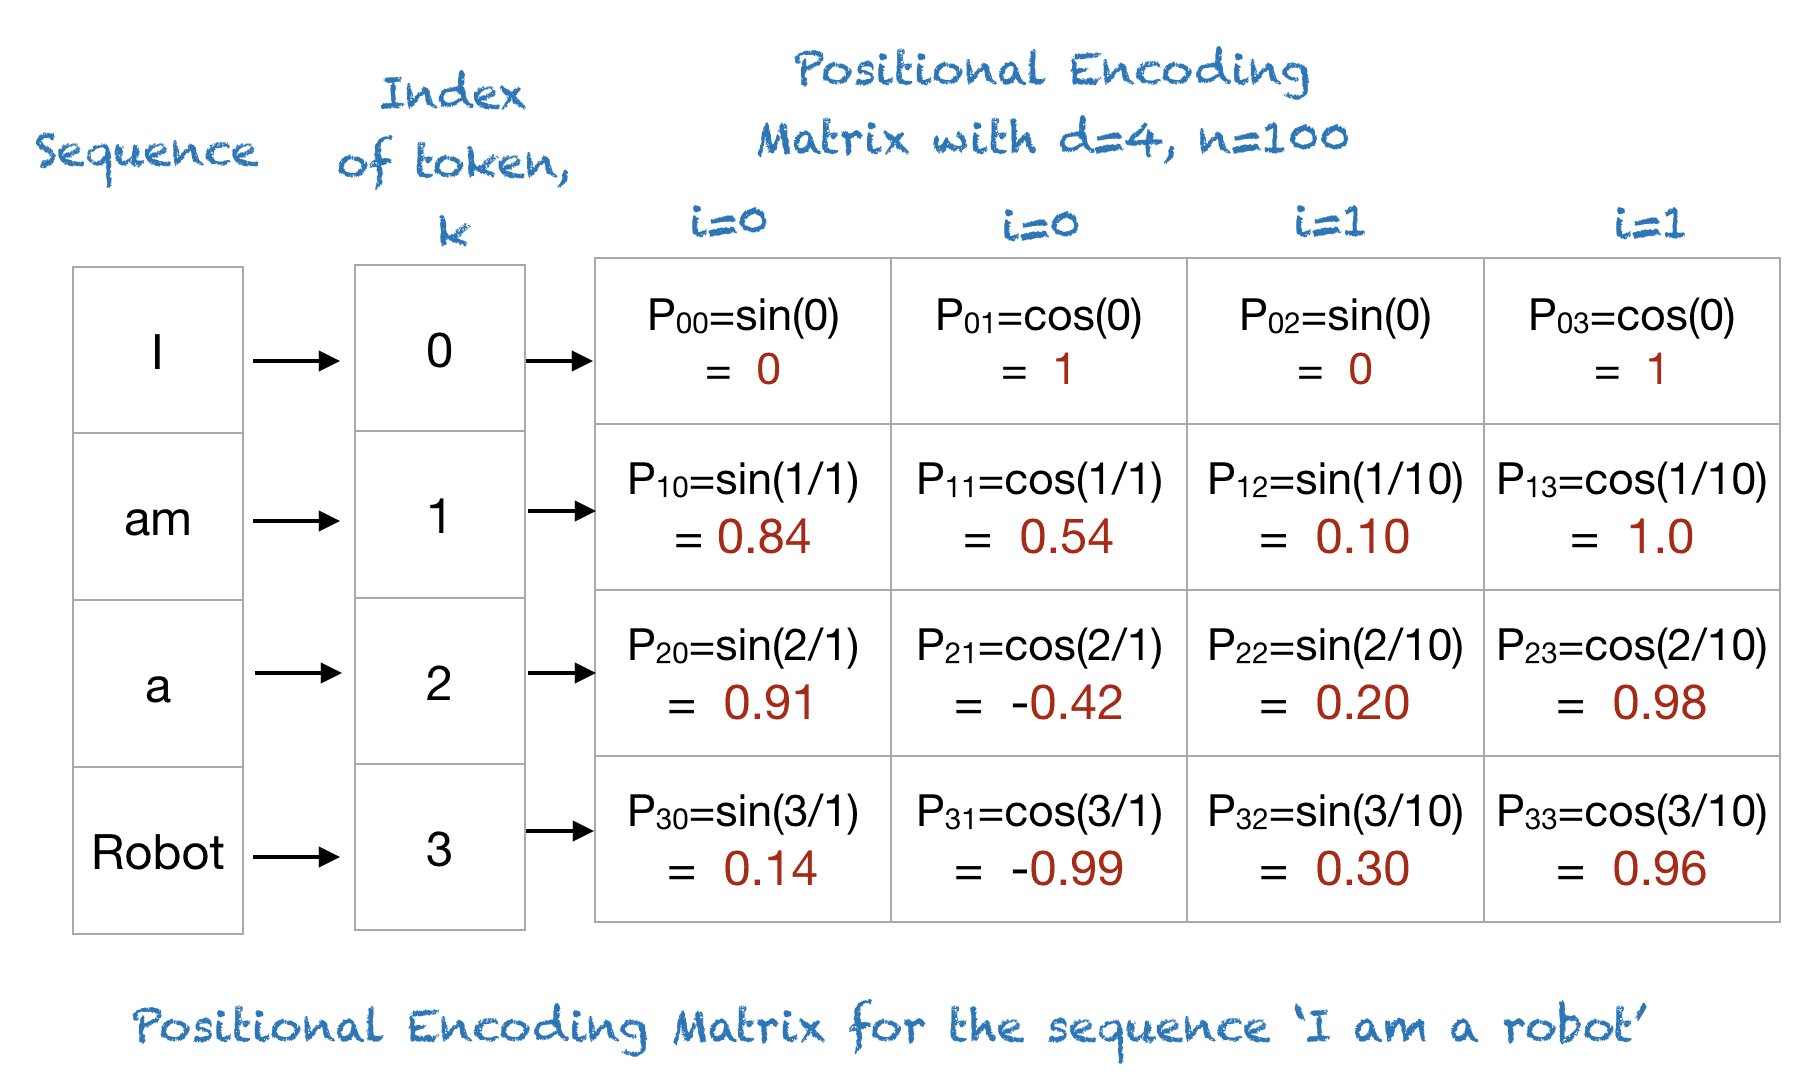

### Example

In [ ]:
d = 100
sequence_length = 200

pe = PositionalEncoding(d)
x = torch.tensor(range(0, sequence_length))
y = pe(x)
print(y.shape)

torch.Size([202, 100])


In [14]:
y[0] # Represents the positional encoding for the first token 

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

Now, I will implement the 2D positional encoding.

Differences: 

- The positional encoding is applied to both the height and width dimensions of the input feature map. e.g., sin, cos functions will be computed for each position in x, and in y.

Let's say we have feature map of size 256, 20, 30 (Channels, Height, Width).

I prefer to think about it like this: 

we have **20x30** **pixels**/positions = **600**, in this case our **sequence_length** = **600**, and the number of **features** (channels) is **256**.

For each position we need to represent it with a **256** dimensional vector. How??! By calculating **Sinusoidal** functions for dimension '**x**' with **128** channels and for dimension '**y**' with **128** channels. in total it's **256**.


? How to deal with different sequence lengths?
in the official implementation of `DETR`, Pad all images to match the maximum size, then use a mask:

- Mask = True where CNN feature corresponds to padded (non-image) areas

- Mask = False where CNN feature corresponds to actual image content

- Positional encoding uses not_mask.cumsum() to only assign coordinates to real image areas



In [133]:
import math
import torch
from torch import nn

from misc import NestedTensor


class PositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, tensor_list: NestedTensor):
        x = tensor_list.tensors
        mask = tensor_list.mask
        assert mask is not None
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        print("x_embed.shape", x_embed.shape, "y_embed.shape", y_embed.shape) # (20, 30), (20, 30), each one represents 600 position
        print("x_embed", x_embed, "y_embed", y_embed)

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device) # dim_t (128,) will be used for the sinusoidal functions, but must be the half, 64 sin, 64 cos
        print("dim_t", dim_t)
        print("dim_t.shape", dim_t.shape)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats) 
        print(dim_t // 2) # (64,) because num_pos_feats=128, so dim_t will be divided by 2

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        print("pos_x", pos_x, "pos_y", pos_y)
        print("pos_x.shape", pos_x.shape, "pos_y.shape", pos_y.shape) # (20, 30, 1, 64), (20, 30, 1, 64)
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        print("xxxpos_x", pos_x, "pos_y", pos_y)
        print("pos_x.shape", pos_x.shape, "pos_y.shape", pos_y.shape) # (20, 30, 1, 64), (20, 30, 1, 64)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2) 
        print("pos", pos.shape)
        return pos


    
# Initialize the positional embedding
pos_embedding = PositionEmbeddingSine(num_pos_feats=128, temperature=10000)

# Simulate feature maps from a CNN backbone (e.g., ResNet)
batch_size = 2
height, width = 20, 30  # Feature map dimensions
channels = 256

# Create fake feature maps
feature_maps = torch.randn(batch_size, channels, height, width)

# Create mask (False = valid positions, True = padded positions)
# For this example, assume all positions are valid
mask = torch.zeros(batch_size, height, width, dtype=torch.bool)

# Create NestedTensor
nested_tensor = NestedTensor(feature_maps, mask)

# Generate positional encodings
pos_encodings = pos_embedding(nested_tensor)

print(f"Feature maps shape: {feature_maps.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Positional encodings shape: {pos_encodings.shape}")


x_embed.shape torch.Size([2, 20, 30]) y_embed.shape torch.Size([2, 20, 30])
x_embed tensor([[[ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         ...,
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.]],

        [[ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         ...,
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.],
         [ 1.,  2.,  3.,  ..., 28., 29., 30.]]]) y_embed tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 2.,  2.,  2.,  ...,  2.,  2.,  2.],
         [ 3.,  3.,  3.,  ...,  3.,  3.,  3.],
         ...,
         [18., 18., 18.,  ..., 18., 18., 18.],
         [19., 19., 19.,  ..., 19., 19., 19.],
         [20., 20., 20.,  ..., 20., 20., 20.]],

        [[ 1.,

In [ ]:
# This implementation assumes all of the input has the same size.

import torch
from torch import nn
from math import sin, cos

class YousPosEncoding(nn.Module):
    def __init__(self, embedding_size, halfed=True):
        super().__init__()
        
        if not halfed:
            self.embedding_size = embedding_size / 2
        else:
            self.embedding_size = embedding_size
        

        
    def forward(self, feature_map):
        feature_maps = torch.randn(1, channels, height, width)

        # Create a tensor of size feature_map[0][0].shape
        x = torch.ones(feature_maps[0][0].shape)
        y = torch.ones(feature_maps[0][0].shape)

        x = torch.cumsum(x, dim=1, dtype=torch.float32) # [1 2 3 .. 30] [1 2 3 .. 30] ... [1 2 3 .. 30] (20, 30)
        y = torch.cumsum(y, dim=0, dtype=torch.float32) # [1 1 1 .. 1] [2 2 2 .. 2] ... [20 20 20 .. 20] (20, 30) length of inner vector is 20

        dim_t = torch.arange(0, channels / 2) # [0 1 2 .. 127] # (128) will be 

        # Applying the temp 
        for i in range(len(dim_t)):
            # Calculate the denominator
            dim_t[i] = 10000 ** ((2 * i) / (channels / 2))

        pos_x = torch.zeros((x.shape[0], x.shape[1], channels // 2))
        pos_y = torch.zeros((y.shape[0], y.shape[1], channels // 2))

        for i in range(height):
            for j in range(width):
                for k in range(channels // 2):
                    if k % 2 == 0:
                        pos_x[i][j][k] = sin(x[i][j] / dim_t[k])
                        pos_y[i][j][k] = sin(y[i][j] / dim_t[k])
                    else: 
                        pos_x[i][j][k] = cos(x[i][j] / dim_t[k])
                        pos_y[i][j][k] = cos(y[i][j] / dim_t[k])

    

I've tried to implement it in the most straightforward way possible, using basic loops and tensor operations. However, I didn't get the correct results, but it's kind of working. 
Now I should skip this and go to the next section in DETR, because I'm just wasting time.
